<a href="https://colab.research.google.com/github/Sihan-A/PyTorch/blob/main/Valkov/20200412/Text_Preprocessing_Sentiment_Analysis_with_BERT_using_huggingface_PyTorch_and_Python_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 58.0 MB/s 
     |████████████████████████████████| 636 kB 67.5 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 3.3 MB 15.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [56]:
import transformers
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch import nn, optim
from torch.utils import data

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] =6,6
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [3]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 49.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 94.4MB/s]


In [4]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [5]:
df.shape

(15746, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'review score')

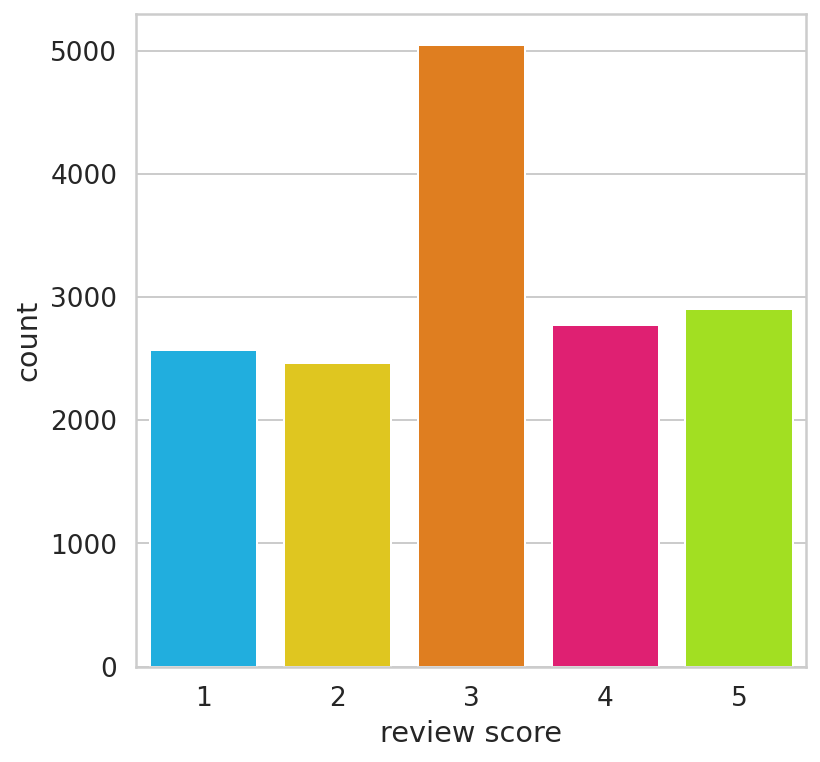

In [7]:
sns.countplot(df.score)
plt.xlabel("review score")

In [8]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

In [9]:
df["sentiment"] = df.score.apply(to_sentiment)

In [10]:
class_name = ["negative", "neutral", "positive"]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


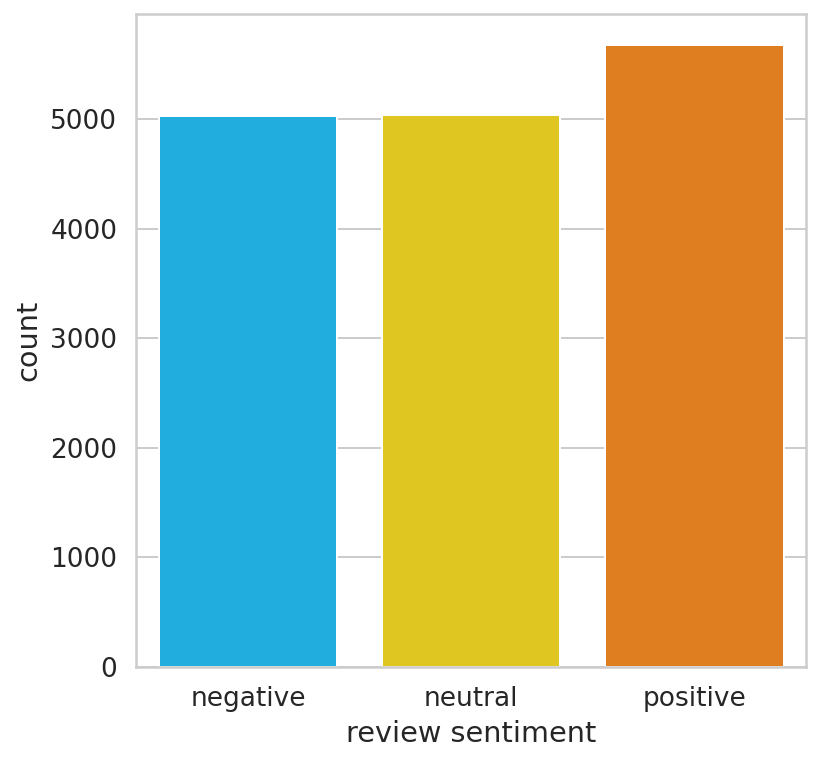

In [11]:
ax = sns.countplot(df.sentiment)
plt.xlabel("review sentiment")
ax.set_xticklabels(class_name);

## Data Preprocessing

In [12]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [14]:
tokens = tokenizer.tokenize(sample_txt)
print(tokens)

['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']


In [15]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


special tokens

In [16]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [17]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [18]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [19]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [20]:
encoding = tokenizer.encode_plus(
    sample_txt,
    truncation=True,
    max_length=32,
    add_special_tokens=True,
    padding='max_length',
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [21]:
encoding['input_ids']

tensor([[ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
         2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])

In [22]:
len(encoding["input_ids"][0])

32

In [23]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [53]:
token_lens =[]
for txt in df.content:
    tokens = tokenizer.encode(txt, truncation = True, max_length=512)
    token_lens.append(len(tokens))

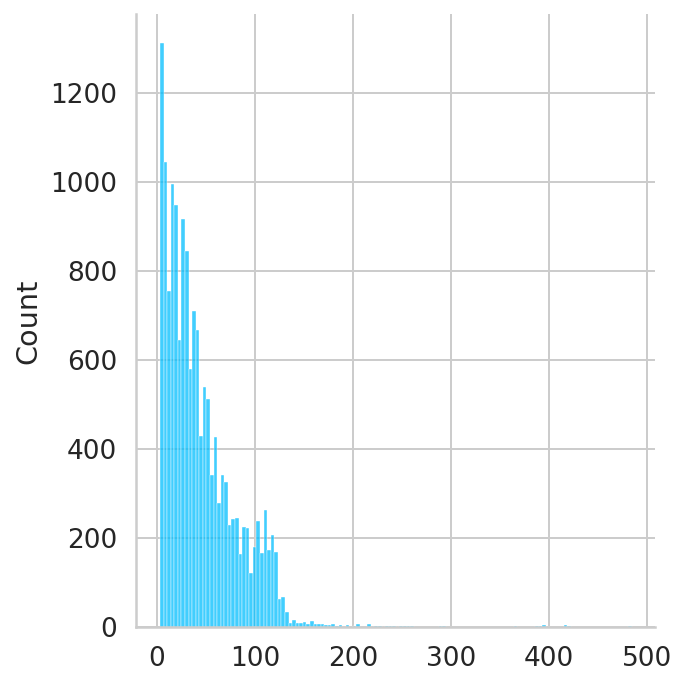

In [54]:
sns.displot(token_lens);

## Create a dataset

In [57]:
class GPReviewDataset(data.Dataset):
    
    def __init__(self, review, target, tokenizer, max_len):
        self.review = review
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
   
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, item):
        review = str(self.review[item])
        encoding = tokenizer.encode_plus(
            review,
            truncation=True,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'targets': torch.tensor(self.target[item], dtype=torch.long)
        }

In [58]:
MAX_LEN=128
BATCH_SIZE=8
EPOCHS=20

In [59]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [60]:
df_train.shape, df_val.shape, df_test.shape

((12596, 12), (1575, 12), (1575, 12))

In [61]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        review=df.content.to_numpy(),
        target=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
    )
    return data.DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2,
    )

In [62]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [63]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['input_ids', 'attention_mask', 'targets'])

In [64]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 1, 128])
torch.Size([8, 1, 128])
torch.Size([8])
